# Generative Models

So far we have seen exampels of supervised learning (such as regression and classification), unsupervised learning (such as clustering and dimensionality reduction). 

In this notebook, we will explore generative models: models that generate new data that looks real. In particular, let's try to generate images.

What is the mathematical question of generative model?


Given a dataset of samples X drawn from some unknown distribution P(X), the goal is to generate new samples that resemble those in X. 
For example, after seeing how some handwritten digits look, we might want to generate new handwritten digits that look like the ones we've seen.



Since we don't know P(X), we need a way to approximate it. One powerful idea is to transform a simple, known distribution—like a Gaussian distribution—into a complex distribution that matches P(X). For example, in image generation, we start with random noise sampled from a Gaussian distribution and apply a series of transformations, learned by the model, to shape this noise into realistic images. This transformation bridges the gap between the simple and complex distributions, allowing us to effectively "create" new samples that look like the data we started with.


## Generate Adversarial Networks (GANs)

As an example, we use the generate adversarial networks (GANs) to generate handwritten digits.

What is the function that we want to learn? In this case, we want to learn the mapping from a random noise vector to a handwritten digit.

The GANs are composed of two networks: the generator and the discriminator. The generator takes a random noise vector and generates a digit. The discriminator takes a digit and outputs the probability that the digit is real (i.e., it was drawn from the training set) or fake (i.e., it was generated by the generator).

- For real sample x, label is “true”, loss is $-\log⁡(D(x))$

- For fake sample G(z), label is “false”, loss is $-\log⁡(1−D(G(z)))$

The objective is

$$
\max_G \min_D V(D, G) = \mathbb{E}_{x \sim {\text{data}}(x)}[-\log D(x)] + \mathbb{E}_{z \sim p}[-\log(1 - D(G(z)))]
$$

where $x\sim {\text{data}}$ is the distribution of the real data and $z\sim p$ is the distribution of the noise vector.

This can be view as a game, where the generator tries to generate data that looks real and the discriminator tries to distinguish between real and fake data. 

Therefore, we see D is trying to minimize the objective V and G is trying to maximize it.


In [1]:
# code adapted from https://github.com/lyeoni/pytorch-mnist-GAN
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [2]:
CUDA = True
DATA_PATH = './data'
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 64
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 5
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 1

In [3]:
CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 2.1.0
CUDA version: 12.1



In [5]:
# Data preprocessing
dataset = dset.MNIST(root=DATA_PATH, download=True,
                     transform=transforms.Compose([
                     transforms.Resize(X_DIM),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:07<00:00, 1276086.94it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 437940.64it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 713038.55it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2016996.16it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



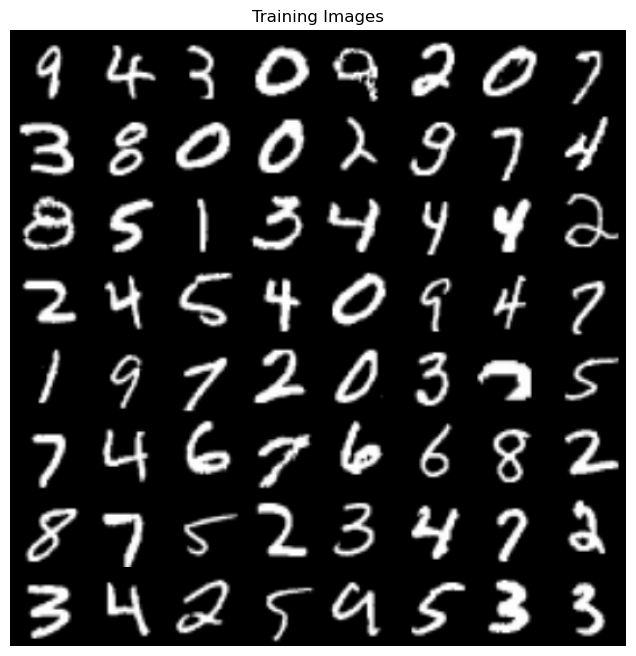

In [6]:
# Plot training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [21]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),
            # 3rd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 2nd layer
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 3rd layer
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4th layer
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # output layer
            nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [23]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
D

In [24]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(64, Z_DIM, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [25]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader, 0):

        # (1) Update the discriminator with real data
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        # all data are real
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        
        # Calculate gradients for D in backward pass
        errD_real.backward()
    

        # (2) Update the discriminator with fake data
        # Generate batch of latent vectors
        noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        # all data are fake
        label.fill_(FAKE_LABEL)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # (3) Update the generator with fake data
        netG.zero_grad()
        label.fill_(REAL_LABEL)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, EPOCH_NUM, i, len(dataloader), errD.item(), errG.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # save the output on fixed noise
        if (iters % 500 == 0) or ((epoch == EPOCH_NUM-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(viz_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


[0/5][0/469]	Loss_D: 1.3298	Loss_G: 5.1147
[0/5][50/469]	Loss_D: 0.0280	Loss_G: 11.4828
[0/5][100/469]	Loss_D: 0.1905	Loss_G: 6.6033
[0/5][150/469]	Loss_D: 0.2183	Loss_G: 4.6722
[0/5][200/469]	Loss_D: 0.8300	Loss_G: 0.2548
[0/5][250/469]	Loss_D: 0.1480	Loss_G: 6.5403
[0/5][300/469]	Loss_D: 0.4902	Loss_G: 3.0466
[0/5][350/469]	Loss_D: 0.1911	Loss_G: 4.2003
[0/5][400/469]	Loss_D: 0.4673	Loss_G: 1.9362
[0/5][450/469]	Loss_D: 0.5644	Loss_G: 0.8092
[1/5][0/469]	Loss_D: 0.1580	Loss_G: 2.6314
[1/5][50/469]	Loss_D: 0.3521	Loss_G: 2.3594
[1/5][100/469]	Loss_D: 0.3190	Loss_G: 2.3963
[1/5][150/469]	Loss_D: 0.8486	Loss_G: 2.6759
[1/5][200/469]	Loss_D: 0.9306	Loss_G: 2.1886
[1/5][250/469]	Loss_D: 0.3523	Loss_G: 1.9581
[1/5][300/469]	Loss_D: 0.5346	Loss_G: 2.2841
[1/5][350/469]	Loss_D: 0.3448	Loss_G: 2.7307
[1/5][400/469]	Loss_D: 0.6787	Loss_G: 4.5042
[1/5][450/469]	Loss_D: 1.1251	Loss_G: 0.7722
[2/5][0/469]	Loss_D: 0.3899	Loss_G: 2.4832
[2/5][50/469]	Loss_D: 0.5419	Loss_G: 3.2823
[2/5][100/469]	Los

In [26]:
# Save the model
torch.save(netG.state_dict(), 'generator.pth')
torch.save(netD.state_dict(), 'discriminator.pth')

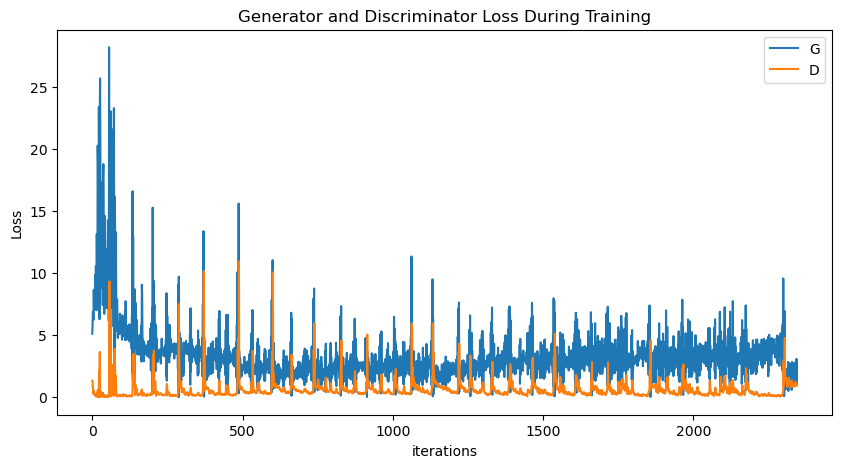

In [27]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")

# plot in log scale
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

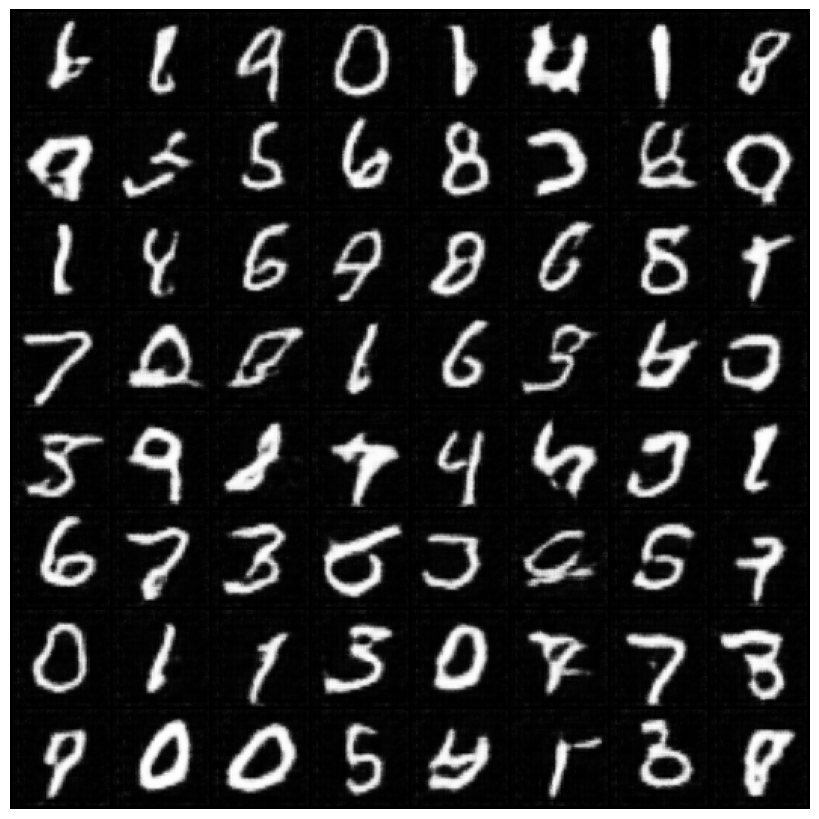

In [28]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch

fig = plt.figure(figsize=(10,8))

# Adjust the subplots to reduce padding
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.axis("off")
ims = [[plt.imshow(i.permute(1,2,0), animated=True)] for i in img_list]

ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())


Generative AI holds immense potential. However, its capabilities also raise concerns:

[Generative AI Has an Intellectual Property Problem](https://hbr.org/2023/04/generative-ai-has-an-intellectual-property-problem)

[Humans are biased. Generative AI is even worse](https://www.bloomberg.com/graphics/2023-generative-ai-bias/)

[Election disinformation takes a big leap with AI being used to deceive worldwide](https://apnews.com/article/artificial-intelligence-elections-disinformation-chatgpt-bc283e7426402f0b4baa7df280a4c3fd)